In [1]:
#import required packages
import os
import ast
import urllib2
import urllib
import pandas as pd
import json
from cStringIO import StringIO
import scipy.stats
from scipy.cluster.vq import whiten
from matplotlib import gridspec
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
import geopandas as gpd
import glob
from fiona.crs import from_epsg
import datetime as dt
import zipfile
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
import pylab as pl
from pandas.io.common import ZipFile
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopandas import GeoDataFrame
import seaborn as sns
from sklearn import cluster
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Task 2: Visualize travel times to get the sense of delays for that selected route.

In [2]:
#read in data
mta = pd.read_csv('all-records_2017-12-10.csv')
mta.head()

,id,lat,lon,bearing,route,direction,service_date,gtfs_trip_id,gtfs_shape_id,gtfs_short_route_name,...,sched_arrive,next_predicted_arrival_time,next_predicted_departure_time,next_stop_distance_from_origin,next_stop_distance_to_vehicle,num_stops_from_call,stops_from_call_presentable,recorded_at_time,stop_distance_difference,at_stop_boolean
0,d254a85a-58dc-4d31-bdaf-ba343654cad9,40.801521,-73.968296,338.48288,MTA NYCT_M60+,1,2017-12-10,MTA NYCT_MQ_D7-Sunday-154300_SBS60_39,MTA_SBS600034,M60-SBS,...,26:22:00,2017-12-11 02:23:30.080000,2017-12-11 02:23:30.080000,15038.55,9.12,0,at stop,2017-12-11 02:23:07,2.609209,1
1,c5321b0c-a245-4a3a-aa94-4a177a917222,40.801521,-73.968296,338.48288,MTA NYCT_M60+,1,2017-12-10,MTA NYCT_MQ_D7-Sunday-154300_SBS60_39,MTA_SBS600034,M60-SBS,...,26:22:00,2017-12-11 02:23:00.100000,2017-12-11 02:23:00.100000,15038.55,9.12,0,at stop,2017-12-11 02:22:36,2.609209,1
2,7c125d31-3517-47d0-8e5c-b0ce1b2f052c,40.801521,-73.968296,338.48288,MTA NYCT_M60+,1,2017-12-10,MTA NYCT_MQ_D7-Sunday-154300_SBS60_39,MTA_SBS600034,M60-SBS,...,26:22:00,2017-12-11 02:22:30.027000,2017-12-11 02:22:30.027000,15038.55,9.12,0,at stop,2017-12-11 02:22:03,2.609209,1
3,6fba1c52-f3ec-499e-a82d-9e5362571030,40.801521,-73.968296,338.48288,MTA NYCT_M60+,1,2017-12-10,MTA NYCT_MQ_D7-Sunday-154300_SBS60_39,MTA_SBS600034,M60-SBS,...,26:22:00,2017-12-11 02:22:00.216000,2017-12-11 02:22:00.216000,15038.55,9.12,0,at stop,2017-12-11 02:21:31,2.609209,1
4,89586119-c515-428c-b851-46f8a4cff420,40.801750,-73.968527,234.76240,MTA NYCT_M60+,1,2017-12-10,MTA NYCT_MQ_D7-Sunday-154300_SBS60_39,MTA_SBS600034,M60-SBS,...,26:22:00,2017-12-11 02:21:00.004000,2017-12-11 02:21:00.004000,15038.55,50.16,0,approaching,2017-12-11 02:20:28,NaN,0


In [3]:
#check route
mta.route.unique()

array(['MTA NYCT_M60+', 'MTABC_Q70+'], dtype=object)

In [4]:
#selecting only entries in route Q70+
df = mta.loc[mta['route'] == 'MTABC_Q70+']

In [5]:
#check direction 
df.direction.unique()

array([0])

In [6]:
#check stops
df.origin_stop_id.unique()

array(['MTA_553332'], dtype=object)

In [7]:
df.destination_stop_id.unique()

array(['MTA_982075'], dtype=object)

In [8]:
df.next_stop_id.unique()

array(['MTA_982075', 'MTA_505192', 'MTA_804110', 'MTA_503875',
       'MTA_503848', 'MTA_551576', 'MTA_553332'], dtype=object)

In [9]:
df['recorded_at_time'] = pd.to_datetime(df['recorded_at_time'])
df['next_predicted_arrival_time'] = pd.to_datetime(df['next_predicted_arrival_time'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
df.sort_values(['recorded_at_time'],ascending=True, inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
df.vehicle_id.unique()

array(['MTABC_7451', 'MTABC_7449', 'MTABC_7448', 'MTABC_7450',
       'MTABC_7453', 'MTABC_7446', 'MTABC_7445', 'MTABC_7472',
       'MTABC_7455', 'MTABC_7463'], dtype=object)

There are 10 buses running the same route

In [12]:
#select only required columns
df1 = df[['id', 'lat', 'lon', 'vehicle_id', 'next_stop_id','next_predicted_arrival_time', 'next_predicted_departure_time','next_stop_distance_from_origin', 'recorded_at_time', 'at_stop_boolean']]
df1.head()

,id,lat,lon,vehicle_id,next_stop_id,next_predicted_arrival_time,next_predicted_departure_time,next_stop_distance_from_origin,recorded_at_time,at_stop_boolean
34612,f958a26b-b017-4654-ae01-c23851c65a33,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:58:07,1
34611,c9720755-0d32-48ed-9eb2-cfcb68d79ec3,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:58:40,1
34610,f851c396-afdb-4ef8-b37b-93f7bbde6af2,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:59:11,1
34609,5a2bdbe4-c4eb-4552-8230-bdfac12ba553,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:59:42,1
34608,eca20a41-4761-4b58-b6cc-ea7453f01631,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:59:42,1


In [13]:
df1['time'] = df1['recorded_at_time'].dt.time

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
df1['time'] = df1['time'].astype(str)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
df1['time'] = df1['time'].str.split(':').str[0]
df1['time'] = df1['time'].astype(int)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Sort times into intervals:

- 0-5
- 6-11
- 12-17
- 18-23

In [16]:
# sorting into time interval bins
df1['TIMEINT'] = pd.cut(df1['time'], bins=[0,5,12,18,300], labels=[1,2,3,4])
df1.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,id,lat,lon,vehicle_id,next_stop_id,next_predicted_arrival_time,next_predicted_departure_time,next_stop_distance_from_origin,recorded_at_time,at_stop_boolean,time,TIMEINT
34612,f958a26b-b017-4654-ae01-c23851c65a33,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:58:07,1,23,4
34611,c9720755-0d32-48ed-9eb2-cfcb68d79ec3,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:58:40,1,23,4
34610,f851c396-afdb-4ef8-b37b-93f7bbde6af2,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:59:11,1,23,4
34609,5a2bdbe4-c4eb-4552-8230-bdfac12ba553,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:59:42,1,23,4
34608,eca20a41-4761-4b58-b6cc-ea7453f01631,40.745688,-73.902816,MTABC_7451,MTA_553332,NaT,NaN,0.01,2017-12-09 23:59:42,1,23,4


In [17]:
#df1[df1['TIMEINT'].isnull()]

In [18]:
df1['TIMEINT'].fillna(1, inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
df1 = df1.loc[df1['at_stop_boolean'] == 1]

# Calculate Duration by Time Interval Bins


In [20]:
d = dict(tuple(df1.groupby('vehicle_id')))

In [21]:
d51 = d['MTABC_7451']
d51.reset_index(drop=True, inplace=True)
d51['time_delta']=np.nan

d49 = d['MTABC_7449']
d49.reset_index(drop=True, inplace=True)
d49['time_delta']=np.nan

d48 = d['MTABC_7448']
d48.reset_index(drop=True, inplace=True)
d48['time_delta']=np.nan

d50 = d['MTABC_7450']
d50.reset_index(drop=True, inplace=True)
d50['time_delta']=np.nan

d53 = d['MTABC_7453']
d53.reset_index(drop=True, inplace=True)
d53['time_delta']=np.nan

d46 = d['MTABC_7446']
d46.reset_index(drop=True, inplace=True)
d46['time_delta']=np.nan

d45 = d['MTABC_7445']
d45.reset_index(drop=True, inplace=True)
d45['time_delta']=np.nan

d72 = d['MTABC_7472']
d72.reset_index(drop=True, inplace=True)
d72['time_delta']=np.nan

d55 = d['MTABC_7455']
d55.reset_index(drop=True, inplace=True)
d55['time_delta']=np.nan

d63 = d['MTABC_7463']
d63.reset_index(drop=True, inplace=True)
d63['time_delta']=np.nan


In [22]:
for i in range(0,(len(d51) - 1)):
    d51['time_delta'][i] = d51.recorded_at_time[i+1] - d51.recorded_at_time[i]
d51;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [23]:
for i in range(0,(len(d49) - 1)):
    d49['time_delta'][i] = d49.recorded_at_time[i+1] - d49.recorded_at_time[i]
d49;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
for i in range(0,(len(d48) - 1)):
    d48['time_delta'][i] = d48.recorded_at_time[i+1] - d48.recorded_at_time[i]
d48;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
for i in range(0,(len(d50) - 1)):
    d50['time_delta'][i] = d50.recorded_at_time[i+1] - d50.recorded_at_time[i]
d50;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
for i in range(0,(len(d53) - 1)):
    d53['time_delta'][i] = d53.recorded_at_time[i+1] - d53.recorded_at_time[i]
d53;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [27]:
for i in range(0,(len(d46) - 1)):
    d46['time_delta'][i] = d46.recorded_at_time[i+1] - d46.recorded_at_time[i]
d46;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [28]:
for i in range(0,(len(d45) - 1)):
    d45['time_delta'][i] = d45.recorded_at_time[i+1] - d45.recorded_at_time[i]
d45;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [29]:
for i in range(0,(len(d72) - 1)):
    d72['time_delta'][i] = d72.recorded_at_time[i+1] - d72.recorded_at_time[i]
d72;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
for i in range(0,(len(d55) - 1)):
    d55['time_delta'][i] = d55.recorded_at_time[i+1] - d55.recorded_at_time[i]
d55;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [31]:
for i in range(0,(len(d63) - 1)):
    d63['time_delta'][i] = d63.recorded_at_time[i+1] - d63.recorded_at_time[i]
d63;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [32]:
d51['time_delta'] = pd.to_timedelta(d51['time_delta']).astype('timedelta64[s]')
d51 = d51.loc[(d51['time_delta'] > 60) & (d51['time_delta'] < 3600)]
#d51['delay'] = (d51['recorded_at_time'] - d51['next_predicted_arrival_time']).astype('timedelta64[s]')

d49['time_delta'] = pd.to_timedelta(d49['time_delta']).astype('timedelta64[s]')
d49 = d49.loc[(d49['time_delta'] > 60) & (d49['time_delta'] < 3600)]
#d49['delay'] = (d49['recorded_at_time'] - d49['next_predicted_arrival_time']).astype('timedelta64[s]')

d48['time_delta'] = pd.to_timedelta(d48['time_delta']).astype('timedelta64[s]')
d48 = d48.loc[(d48['time_delta'] > 60) & (d48['time_delta'] < 3600)]
#d48['delay'] = (d48['recorded_at_time'] - d48['next_predicted_arrival_time']).astype('timedelta64[s]')

d50['time_delta'] = pd.to_timedelta(d50['time_delta']).astype('timedelta64[s]')
d50 = d50.loc[(d50['time_delta'] > 60) & (d50['time_delta'] < 3600)]
#d50['delay'] = (d50['recorded_at_time'] - d50['next_predicted_arrival_time']).astype('timedelta64[s]')

d53['time_delta'] = pd.to_timedelta(d53['time_delta']).astype('timedelta64[s]')
d53 = d53.loc[(d53['time_delta'] > 60) & (d53['time_delta'] < 3600)]
#d53['delay'] = (d53['recorded_at_time'] - d53['next_predicted_arrival_time']).astype('timedelta64[s]')

d46['time_delta'] = pd.to_timedelta(d46['time_delta']).astype('timedelta64[s]')
d46 = d46.loc[(d46['time_delta'] > 60) & (d46['time_delta'] < 3600)]
#d46['delay'] = (d46['recorded_at_time'] - d46['next_predicted_arrival_time']).astype('timedelta64[s]')

d45['time_delta'] = pd.to_timedelta(d45['time_delta']).astype('timedelta64[s]')
d45 = d45.loc[(d45['time_delta'] > 60) & (d45['time_delta'] < 3600)]
#d45['delay'] = (d45['recorded_at_time'] - d45['next_predicted_arrival_time']).astype('timedelta64[s]')

d72['time_delta'] = pd.to_timedelta(d72['time_delta']).astype('timedelta64[s]')
d72 = d72.loc[(d72['time_delta'] > 60) & (d72['time_delta'] < 3600)]
#d72['delay'] = (d72['recorded_at_time'] - d72['next_predicted_arrival_time']).astype('timedelta64[s]')

d55['time_delta'] = pd.to_timedelta(d55['time_delta']).astype('timedelta64[s]')
d55 = d55.loc[(d55['time_delta'] > 60) & (d55['time_delta'] < 3600)]
#d55['delay'] = (d55['recorded_at_time'] - d55['next_predicted_arrival_time']).astype('timedelta64[s]')

d63['time_delta'] = pd.to_timedelta(d63['time_delta']).astype('timedelta64[s]')
d63 = d63.loc[(d63['time_delta'] > 60) & (d63['time_delta'] < 3600)]
#d63['delay'] = (d63['recorded_at_time'] - d63['next_predicted_arrival_time']).astype('timedelta64[s]')

In [33]:
dbus = pd.concat([d51, d49, d48, d50, d53, d46, d45, d72, d55, d63], ignore_index=True)

In [34]:
avg_stop_time = dbus.groupby(['next_stop_id']).mean().reset_index()

In [35]:
avg_stop_time = avg_stop_time.set_index('next_stop_id').reindex(['MTA_553332', 'MTA_551576', 'MTA_804110', 
                                                                 'MTA_503875', 'MTA_503848', 'MTA_505192', 
                                                                 'MTA_982075']).reset_index()

In [36]:
avg_stop_time = avg_stop_time[['next_stop_id', 'next_stop_distance_from_origin','time_delta']]
avg_stop_time['avg_travel_duration_mins'] = avg_stop_time['time_delta'] / 60
avg_stop_time

,next_stop_id,next_stop_distance_from_origin,time_delta,avg_travel_duration_mins
0,MTA_553332,0.01,374.309091,6.238485
1,MTA_551576,1109.27,758.130841,12.635514
2,MTA_804110,6219.88,477.843750,7.964062
3,MTA_503875,7863.43,218.444444,3.640741
4,MTA_503848,8141.73,1086.258065,18.104301
5,MTA_505192,13860.99,670.310345,11.171839
6,MTA_982075,15252.51,492.685714,8.211429


In [37]:
dbus_viz = dbus

In [38]:
dbus_viz['time'] = dbus_viz['recorded_at_time'].dt.time

In [39]:
vals_to_replace = {'MTA_553332':'1', 'MTA_551576':'2', 'MTA_804110':'3', 'MTA_503875':'4', 'MTA_503848':'5', 
                   'MTA_505192':'6', 'MTA_982075':'7'}
dbus_viz['next_stop_id'] = dbus_viz['next_stop_id'].map(vals_to_replace)

In [40]:
dbus_viz = dbus_viz[['vehicle_id', 'next_stop_id', 'time', 'time_delta']]
dbus_viz.head()

,vehicle_id,next_stop_id,time,time_delta
0,MTABC_7451,1,00:00:14,288.0
1,MTABC_7451,2,00:05:02,829.0
2,MTABC_7451,5,00:19:23,952.0
3,MTABC_7451,7,00:37:23,64.0
4,MTABC_7451,1,00:40:02,158.0


In [41]:
avg_time = dbus_viz.groupby(['next_stop_id']).mean()
avg_time.reset_index(inplace=True)

In [42]:
#dbus_viz.to_csv('addrow.csv')

In [43]:
viz2 = pd.read_csv('row_upd.csv')

In [44]:
viz2['time'] = pd.to_datetime(viz2['time'], format='%H:%M:%S').dt.time

In [45]:
avg_time = pd.concat([avg_time]*111, ignore_index=True)

In [46]:
viz2['avg'] = avg_time['time_delta']
viz2.head()

,vehicle_id,next_stop_id,time,time_delta,avg
0,MTABC_7451,1,00:00:14,288.0,374.309091
1,MTABC_7451,2,00:05:02,829.0,758.130841
2,MTABC_7451,3,NaN,NaN,477.843750
3,MTABC_7451,4,NaN,NaN,218.444444
4,MTABC_7451,5,00:19:23,952.0,1086.258065


In [47]:
#fill nan with average values
viz2.time_delta.fillna(viz2.avg, inplace=True)

In [48]:
no_time = viz2[viz2.isnull().any(axis=1)]

In [49]:
no_firststop = no_time.loc[no_time['next_stop_id'] == 1]

In [50]:
def time_plus(time, timedelta):
    start = datetime.datetime(
        2000, 1, 1,
        hour=time.hour, minute=time.minute, second=time.second)
    end = start + timedelta
    return end.time()

In [51]:
#calculate time, fill nan with previous time add average values
for i in no_time.index:
    viz2['time'][i] = time_plus(viz2['time'][i-1],datetime.timedelta(seconds=viz2['time_delta'][i-1]))
viz2;

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [52]:
viz2.to_csv('checkrow.csv')

In [53]:
viznow = pd.read_csv('rowchecked.csv')

In [54]:
viznow['time'] = pd.to_datetime(viznow['time'], format='%H:%M:%S')

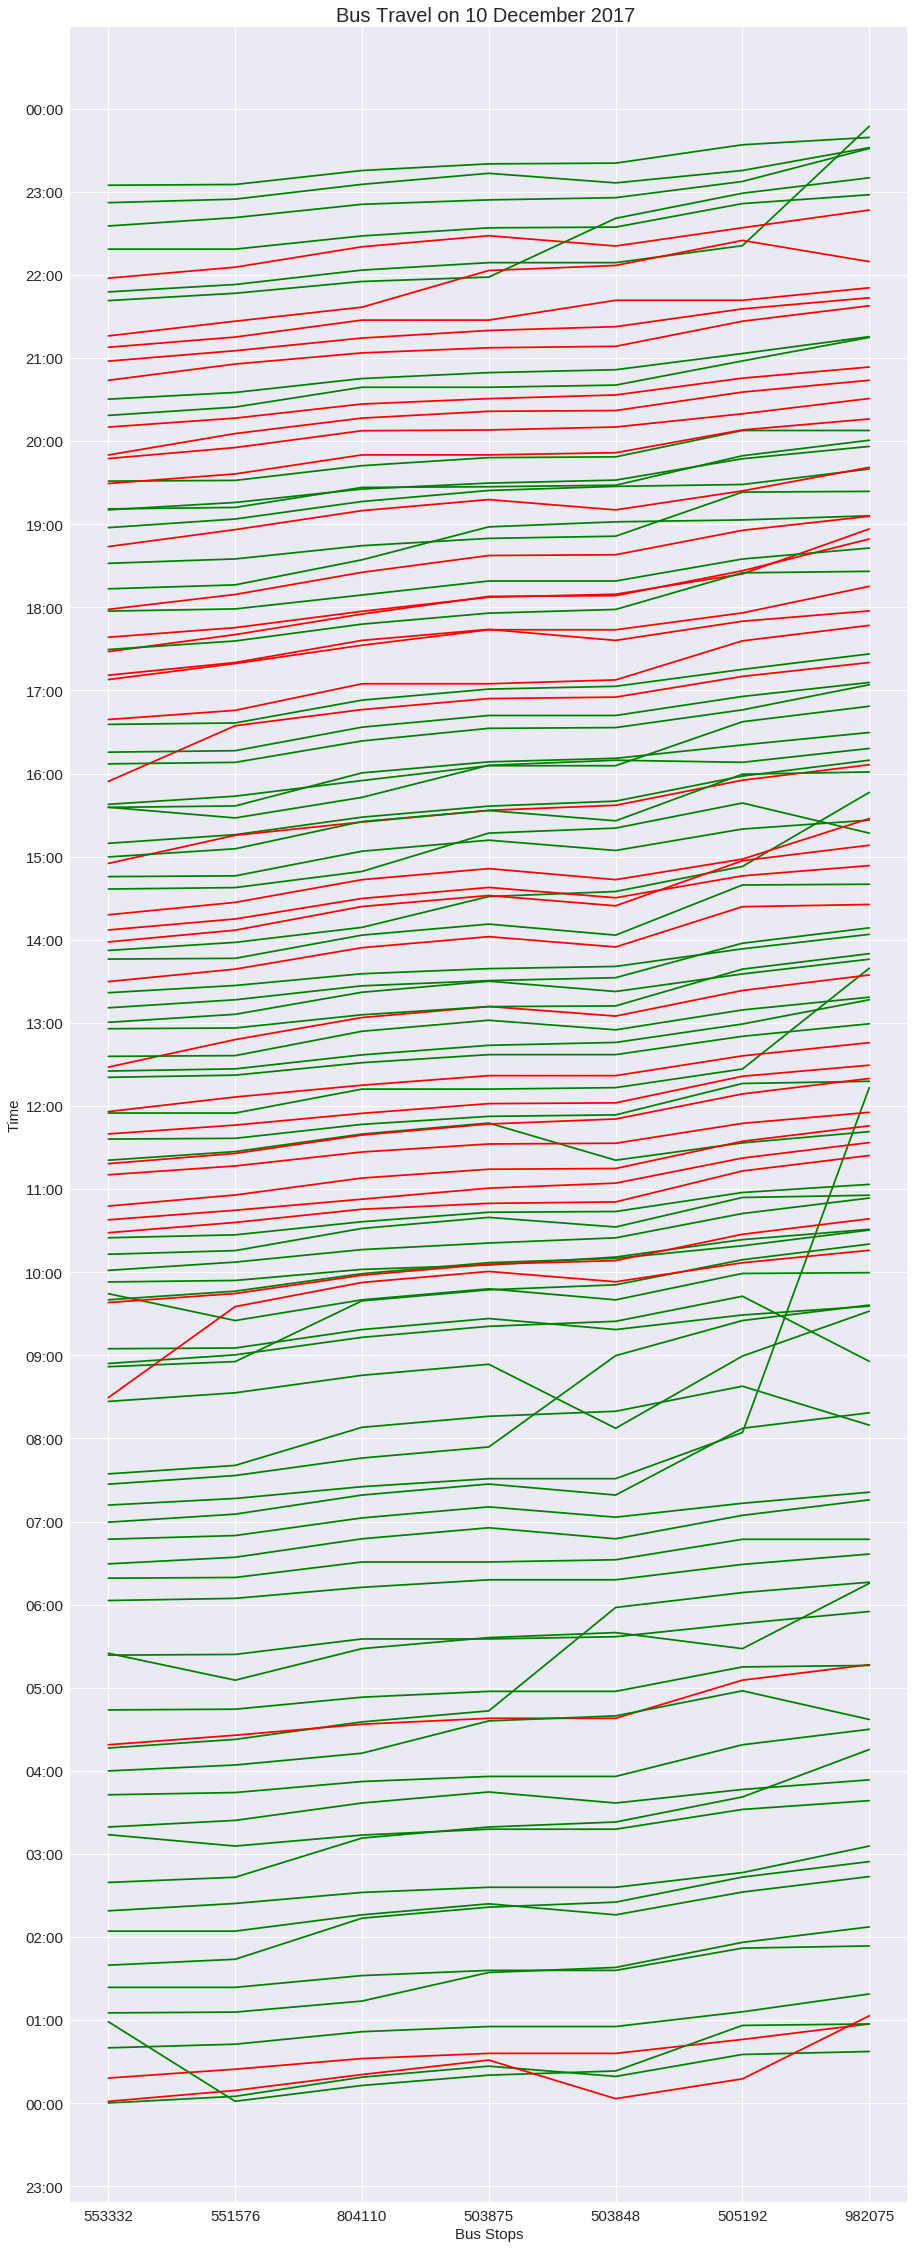

In [55]:
fig = plt.figure(figsize= (15,40))
ax = fig.add_subplot(111)
for i in range (0,756,7):
    color = 'r' if (viznow['Delay'][i] == 1).all() else 'g'
    line = ax.plot(viznow['next_stop_id'].iloc[i:i+7,],viznow.time.iloc[i:i+7,], c=color)
ax.set_xticklabels(ax.get_xticks(), fontsize=15)
labels = ['553332', '551576', '804110', '503875', '503848', 
                   '505192', '982075']
plt.xticks(viznow['next_stop_id'], labels)
ax.yaxis.set_major_locator(HourLocator())
ax.yaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Bus Stops", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.title('Bus Travel on 10 December 2017 ', fontsize=20);
plt.savefig('bus_delay_10122017.png')